In [4]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as spio
import glob
import imageio
import pickle

## Subsection A: Visualise Data

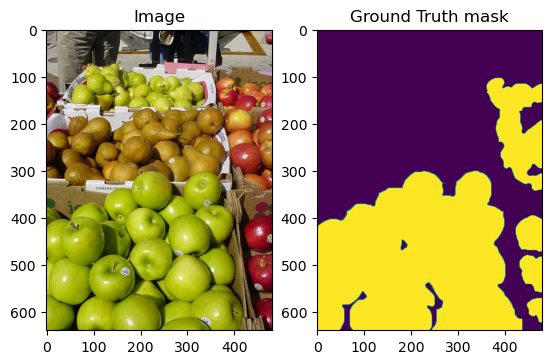

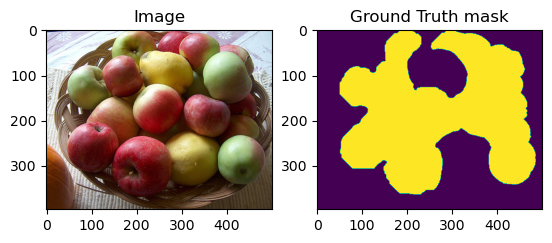

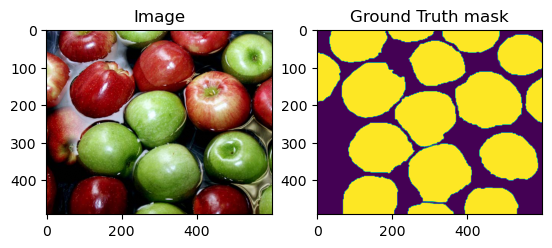

In [5]:
#Import data first
images = glob.glob('apples/*.jpg')
mask_images = glob.glob('apples/*.png')

#Create "readable" lists to plot images
images_list = []
for image in images:
    im = plt.imread(image)
    images_list.append(im/255) #As shown in matlab code given

mask_images_list = []
for mask_image in mask_images:
    im = plt.imread(mask_image)
    mask_images_list.append(im[:,:,1]) #We want binary values only

#Plot each image with its respectful ground truth mask
for n in range(len(images)):
    fig,(ax1,ax2) = plt.subplots(1,2)
    ax1.imshow(images_list[n])
    ax1.set_title('Image')
    ax2.imshow(mask_images_list[n])
    ax2.set_title('Ground Truth mask')


In [6]:
#Now I need to create vectors for training.
#I need a vector of every pixel of an apple, according to truth mask, for every image in training
#Same thing for pixels of no apples, according to truth mask, for every image in training
apple_pixel_list = []
not_apple_pixel_list = []

for image in range(len(mask_images_list)):
    for x in range(mask_images_list[image].shape[0]):
        for y in range(mask_images_list[image].shape[1]):
            #Know to what list the pixel is getting appended to
            if mask_images_list[image][x,y]== 0: #Pixel where there is no apple
                not_apple_pixel_list.append(images_list[image][x,y,:])
            else: #Pixel where there is an apple
                apple_pixel_list.append(images_list[image][x,y,:])

#Convert them to numpy arrays:
pixel_apple = np.transpose(np.array(apple_pixel_list)) #Transpose them to have D by N, as desired in practicals
pixel_not_apple = np.transpose(np.array(not_apple_pixel_list)) #Transpose them to have D by N, as desired in practicals

#Sanity check
print(pixel_apple.shape)
print(pixel_not_apple.shape)

(3, 429649)
(3, 370651)


## Subsection B: Train Model

In [7]:
#Load in functions defined in practical

def fitMixGauss(data, k):
    """
    Estimate a k MoG model that would fit the data. Incremently plots the outcome.
               
    
    Keyword arguments:
    data -- d by n matrix containing data points.
    k -- scalar representing the number of gaussians to use in the MoG model.
    
    Returns: 
    mixGaussEst -- dict containing the estimated MoG parameters.
    
    """
    
    #     MAIN E-M ROUTINE  
    #     In the E-M algorithm, we calculate a complete posterior distribution over                                  
    #     the (nData) hidden variables in the E-Step.  
    #     In the M-Step, we update the parameters of the Gaussians (mean, cov, w).   
    
    nDims, nData = data.shape

    log_likelihood_list = []

    # we will initialize the values to random values
    mixGaussEst = dict()
    mixGaussEst['d'] = nDims
    mixGaussEst['k'] = k
    mixGaussEst['weight'] = (1 / k) * np.ones(shape=(k))
    mixGaussEst['mean'] = 2 * np.random.randn(nDims, k)
    mixGaussEst['cov'] = np.zeros(shape=(nDims, nDims, k))
    for cGauss in range(k):
        mixGaussEst['cov'][:, :, cGauss] = 2.5 + 1.5 * np.random.uniform() * np.eye(nDims)
        
    logLike = getMixGaussLogLike(data, mixGaussEst)
    print('Log Likelihood Iter 0 : {:4.3f}\n'.format(logLike))

    log_likelihood_list.append(logLike) #Append initial loglike value

    nIter = 30

    for cIter in range(nIter):

        # ===================== =====================
        # Expectation step
        # ===================== =====================

        responsabilities = []
        for cData in range(nData):
            # TO DO (g) : fill in column of 'hidden' - calculate posterior probability that
            # this data point came from each of the Gaussians
            # replace this:

            thisData = data[:, cData]
            #Need to update responsabilities matrix
            l = []
            for k_1 in range(k):
                #Need to first calculate probability of each datapoint being in k1-th dist and multiply it for chance of being in that dist
                #gamma_k as shown in cribsheet
                gamma_k = mixGaussEst["weight"][k_1]
                #Probability of d-dimensional data to have been generated from k-th multivariate gaussian
                constant_term = (2*np.pi)**(-0.5*mixGaussEst["d"])
                add_det_term = constant_term * (np.linalg.det(mixGaussEst["cov"][:,:,k_1])**(-0.5))
                difference_vector = thisData - mixGaussEst["mean"][:,k_1]
                exp_term = np.exp(-0.5*(np.transpose(difference_vector) @ np.linalg.inv(mixGaussEst["cov"][:,:,k_1]) @ difference_vector))

                l.append(gamma_k*add_det_term * exp_term)

            l = np.array(l)
            #Need to normalise the responsabilities
            l = l/(np.sum(l))
            #Add it to responsabilities
            responsabilities.append(l)
            
        responsabilities = np.transpose(np.array(responsabilities))

        # ===================== =====================
        # Maximization Step
        # ===================== =====================
        # for each constituent Gaussian
        for cGauss in range(k):

            mixGaussEst['weight'][cGauss] = np.sum(responsabilities[cGauss,:])/nData

            mixGaussEst['mean'][:,cGauss] = np.sum(responsabilities[cGauss,:]*data,axis=1)/np.sum(responsabilities[cGauss,:])

            diff = np.transpose(data)-mixGaussEst['mean'][:,cGauss]
            first = np.transpose(diff) * responsabilities[cGauss,:]
            second = first @ diff
            mixGaussEst['cov'][:,:,cGauss] = second/ np.sum(responsabilities[cGauss,:])

        # calculate the log likelihood
        logLike = getMixGaussLogLike(data, mixGaussEst)
        print('Log Likelihood After Iter {} : {:4.3f}\n'.format(cIter, logLike))
        
        log_likelihood_list.append(logLike) #Append after every iteration


    return mixGaussEst, log_likelihood_list

def getMixGaussLogLike(data, mixGaussEst): 
    """
    Calculate the log likelihood for the whole dataset under a mixture of Gaussians model.
    
    Keyword arguments:
    data -- d by n matrix containing data points.
    mixGaussEst -- dict containing the mixture of gaussians parameters.

    Returns: 
    logLike -- scalar containing the log likelihood.
    
    """
    
    data = np.atleast_2d(data)
    
    # find total number of data items                                                                  
    nDims, nData = data.shape                                                                          
    
    # initialize log likelihoods                                                                       
    logLike = 0
                                                                                                       
    # run through each data item                                                                       
    for cData in range(nData):                                                                         
        thisData = data[:, cData]

        like = []
        for k in range(mixGaussEst["k"]):
            #gamma_k as shown in cribsheet
            gamma_k = mixGaussEst["weight"][k]
            #Probability of d-dimensional data to have been generated from k-th multivariate gaussian
            constant_term = (2*np.pi)**(-0.5*mixGaussEst["d"])
            add_det_term = constant_term * (np.linalg.det(mixGaussEst["cov"][:,:,k])**(-0.5))
            difference_vector = thisData - mixGaussEst["mean"][:,k]
            exp_term = np.exp(-0.5*(np.transpose(difference_vector) @ np.linalg.inv(mixGaussEst["cov"][:,:,k]) @ difference_vector))
            prob = add_det_term * exp_term
            #Add the log of the multiplication of both terms
            like.append(gamma_k*prob)

        like = np.array(like)
        logLike += np.log(np.sum(like))

    return  logLike

def getMixGausLike_vector(data, mixGaussEst): 
    """
    Return vector of length N, each entry being the likelihood of n-th datapoint
    
    Keyword arguments:
    data -- d by n matrix containing data points.
    mixGaussEst -- dict containing the mixture of gaussians parameters.

    Returns: 
    likelihood_vector: vector of length N, each entry being the likelihood of n-th datapoint
    
    """
                                                                    
    nDims, nData = data.shape                                                                          
    
    # initialize log likelihoods                                                                       
    likelihood_vector = np.zeros(nData)
    for k_1 in range(mixGaussEst["k"]):
        diff = data - mixGaussEst["mean"][:,k_1][:,None]
        exp_term = np.exp(-0.5*np.sum((np.dot(np.transpose(diff), np.linalg.pinv(mixGaussEst["cov"][:,:,k_1]))*np.transpose(diff)),axis=1))
        denominator = ((2*np.pi)**(nDims/2)) * (np.linalg.det(mixGaussEst["cov"][:,:,k_1]))**0.5
        likelihood_vector += mixGaussEst["weight"][k_1] * (exp_term / denominator)

    return likelihood_vector

In [47]:
#Run this once due to heavy computation power
#I would have loved to vectorise my EM algorithm for responsibilities, but due to time constraint, was not possible to do so
k = 3 #Choose amount of multivariate gaussians, I choose 3
mix_gauss_dict_apple, log_like_apple = fitMixGauss(pixel_apple, k)
mix_gauss_dict_apple_not, log_like_apple_not = fitMixGauss(pixel_not_apple, k)

Log Likelihood Iter 0 : -2680625.845

Log Likelihood After Iter 0 : 283652.044

Log Likelihood After Iter 1 : 283716.908

Log Likelihood After Iter 2 : 284830.152

Log Likelihood After Iter 3 : 296475.420

Log Likelihood After Iter 4 : 313687.950

Log Likelihood After Iter 5 : 325426.178

Log Likelihood After Iter 6 : 336828.588

Log Likelihood After Iter 7 : 349758.422

Log Likelihood After Iter 8 : 366438.412

Log Likelihood After Iter 9 : 391192.376

Log Likelihood After Iter 10 : 419551.038

Log Likelihood After Iter 11 : 445178.412

Log Likelihood After Iter 12 : 468783.829

Log Likelihood After Iter 13 : 492911.032

Log Likelihood After Iter 14 : 516354.476

Log Likelihood After Iter 15 : 536091.168

Log Likelihood After Iter 16 : 552910.604

Log Likelihood After Iter 17 : 567393.228

Log Likelihood After Iter 18 : 577860.493

Log Likelihood After Iter 19 : 585012.156

Log Likelihood After Iter 20 : 590446.295

Log Likelihood After Iter 21 : 594898.840

Log Likelihood After Iter 

In [53]:
""" #Save dictionaries
with open('mix_gauss_dict_apple.pkl', 'wb') as fp:
    pickle.dump(mix_gauss_dict_apple, fp)
    print('dictionary saved successfully to file')
    
with open('mix_gauss_dict_apple_not.pkl', 'wb') as fp:
    pickle.dump(mix_gauss_dict_apple_not, fp)
    print('dictionary saved successfully to file') """
#Save log_like lists
np.save('log_like_apple.npy', np.array(log_like_apple, dtype=object), allow_pickle=True)
np.save('log_like_apple_not.npy', np.array(log_like_apple_not, dtype=object), allow_pickle=True)

In [72]:
#Load dictionaries
with open('mix_gauss_dict_apple.pkl', 'rb') as fp:
    mix_gauss_dict_apple = pickle.load(fp)

with open('mix_gauss_dict_apple_not.pkl', 'rb') as fp:
    mix_gauss_dict_apple_not = pickle.load(fp)

#Load log_like lists
log_like_apple = np.load('log_like_apple.npy', allow_pickle=True)
log_like_apple_not = np.load('log_like_apple_not.npy', allow_pickle=True)


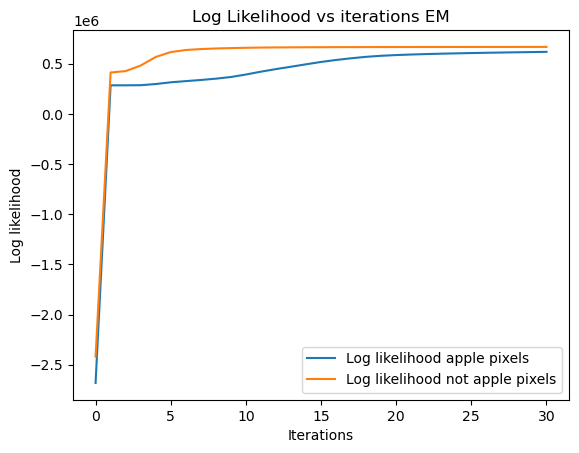

In [73]:
#Plot how likelihood increases per EM iteration:
plt.plot(log_like_apple, label="Log likelihood apple pixels")
plt.plot(log_like_apple_not, label="Log likelihood not apple pixels")
plt.xlabel("Iterations")
plt.ylabel("Log likelihood")
plt.title("Log Likelihood vs iterations EM")
plt.legend()
plt.show()

In subsection B, we have trained our model with the provided training images.
\
\
We have used a mixture of multivariate gaussians to recognise the colors of pixels of apples. Given that the colors of pixels are RGB values, each pixel has $D=3$ features. Thus our multivariate gaussians are imposed to be 3-dimensional gaussians.
\
\
However, the number of multivariate gaussian in our mixture (parameter $k$) needs to be assigned manually. Ideally, we would have a method to tune such parameter (k-fold validation for example), but given this was not done in this exercise, such parameter needs to be chosen using a personal bias.
\
\
Evidently, as k increases, we are increasing the risk of our model overfitting to training data. I chose $k=3$ based on my personal (potentially wrong) preconception of there being three types of colored apples (red, green, yellow). This way, each type of apple has a single 3-dimensional gaussian to recognise it.
\
\
Finally, I just want to comment on the validity of our EM algorithm. One can see from the graph above, both likelihoods appear to converge, re-assuring us our EM algorithm fit our mixture of multivariate gaussians properly.

## Subsection C

In [74]:
#Do the same to load in data as in A
#Now we only have coloured images, no ground truth mask, we are supposed to generate the mask images
images = glob.glob("testApples/*.jpg")
testing_images_list = []
for image in images:
    im = plt.imread(image)
    testing_images_list.append(im/255)

In [75]:
def posterior(images_list, prior_apple, prior_apple_not, mixgauss_apple, mixgauss_apple_not):
    posterior_total = []
    for i in range(len(images_list)):
        image = images_list[i] 
        #image is a 3 dimensional array, we want all pixels in a row. We reshape it below
        original_shape0 = image.shape[0] #need to save them for later
        original_shape1 = image.shape[1] #need to save them for later
        image = image.reshape(image.shape[0] * image.shape[1], image.shape[2])
        #We transpose it to satisfy the notation used in practical
        image = np.transpose(image)
        #We now calculate the posterior for each pixel
        apple_likelihood_vector = getMixGausLike_vector(image, mixgauss_apple)
        not_apple_likelihood_vector = getMixGausLike_vector(image,mixgauss_apple_not)
        posterior = (apple_likelihood_vector*prior_apple) / ((apple_likelihood_vector*prior_apple) + (not_apple_likelihood_vector*prior_apple_not))
        #reshape it to be plotted later
        posterior = posterior.reshape(original_shape0,original_shape1)
        #Finally append it to posterior_total
        posterior_total.append(posterior)

    return posterior_total

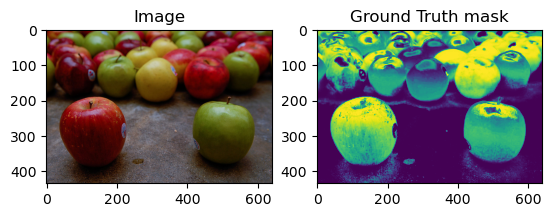

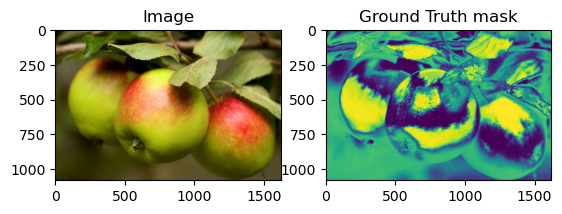

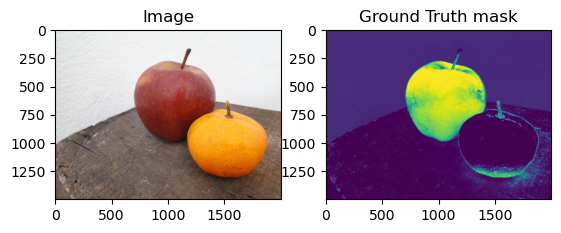

In [76]:
#Plot the posteriors
#We first need to calculate priors of course, I make them be the ratio of apple pixels vs not apple pixels
apple_prior = pixel_apple.shape[1] / (pixel_apple.shape[1] + pixel_not_apple.shape[1])
apple_not_prior = 1 - apple_prior

#calculate posteriors:
posterior_list = posterior(testing_images_list, apple_prior, apple_not_prior, mix_gauss_dict_apple, mix_gauss_dict_apple_not)

#Repeat plotting process as A
for n in range(len(testing_images_list)):
    fig,(ax1,ax2) = plt.subplots(1,2)
    ax1.imshow(testing_images_list[n])
    ax1.set_title('Image')
    ax2.imshow(posterior_list[n])
    ax2.set_title('Ground Truth mask')

In subsection C we have attempted to test our model by predicting the posterior of each testing image.
\
\
One can see our model has some pretty clear flaws:
\
\
In the first image, one can recognise a failure for our model to predict yellow apples (middle of the image). This can be explained when studying our training images, as there is a complete lack of yellow apples within such training data. Therefore, our model has never "seen" yellow apples, or has never been trained to recognise them.
\
\
In the second image, one can appreciate our model's struggle to recognise apples with shade or too much light on them. Since there are examples of such apples in the training data, it brings us to question our model choice (evidently, more data would be better, but the problem appears to be qualitative not quantitative, since it recognises other colors of apples well). This may have been caused by our low parameter (k), it would be worth studying our model for larger values of k, as perhaps that would allow it to recognise red, green, yellow and shadowed or bright apples.
\
\
Lastly, the third image is the one that performed the best, we can recognise a really clear distinction between the apple and what appears to be an orange. One can also appreciate the fact that the apple is not shadowed nor has too much light on it

## Subsection D

As far as I understood, we need to acquire the true positive rate and the false positive rate.
\
\
We do that by counting the number of True Positives, False Positives, True Negatives, False Negatives.
\
\
The trick is doing this for different threshold values in order to see how such rates change depending to such threshold. This way, we can determine which threshold fits our model best.

In [77]:
#We start by loading in the ground truth mask image provided to us
images = glob.glob("testApples/*.png")
test_mask_image = [] #list to be consistent with past subsections
for image in images:
    im = plt.imread(image)
    test_mask_image.append(im[:,:,1]) #As specified in A

In [78]:
#We proceed by defining an ROC function
def ROC(threshold_epsilon, posterior, ground_truth_mask_image):
    #First define the threshold values we will explore
    threshold_values = np.arange(0,1,threshold_epsilon) #Our values in each pixel can only go from 0 to 1
    true_positive_rate = [] #Lists to plot later
    false_positive_rate = [] #Lists to plot later

    #Calculate for each threshold value
    for threshold in threshold_values:
        true_positive_count = 0
        false_positive_count = 0
        true_negative_count = 0
        false_negative_count = 0
        #Go over every pixel in the posterior
        for x in range(posterior.shape[0]):
            for y in range(posterior.shape[1]):
                #bunch of if statements to get the correct count
                if posterior[x,y] >= threshold and ground_truth_mask_image[x,y] == 1:
                    true_positive_count += 1
                elif posterior[x,y] < threshold and ground_truth_mask_image[x,y] == 1:
                    false_negative_count += 1
                elif posterior[x,y] < threshold and ground_truth_mask_image[x,y] == 0:
                    true_negative_count += 1
                elif posterior[x,y] >= threshold and ground_truth_mask_image[x,y] == 0:
                    false_positive_count += 1

        #After having counted every pixel, append values to lists
        #In first threshold values, some counts are 0 and makes the division explode!!!
        #Take it into account with if statements

        #true_positive rate
        if true_positive_count + false_negative_count == 0:
            true_positive_rate.append(0)
        else:
            true_positive_rate.append(true_positive_count/(true_positive_count + false_negative_count))
        
        #false_positive_rate
        if true_negative_count + false_positive_count == 0:
            false_positive_rate.append(0)
        else:
            false_positive_rate.append(false_positive_count/(true_negative_count + false_positive_count))
    
    return true_positive_rate, false_positive_rate

In [79]:
#Run the function with our ground truth masked image and posterior we obtained for that image
threshold_epsilon = 0.05
true_positive_rate, false_positive_rate = ROC(threshold_epsilon, posterior_list[2], test_mask_image[0])

<function matplotlib.pyplot.show(close=None, block=None)>

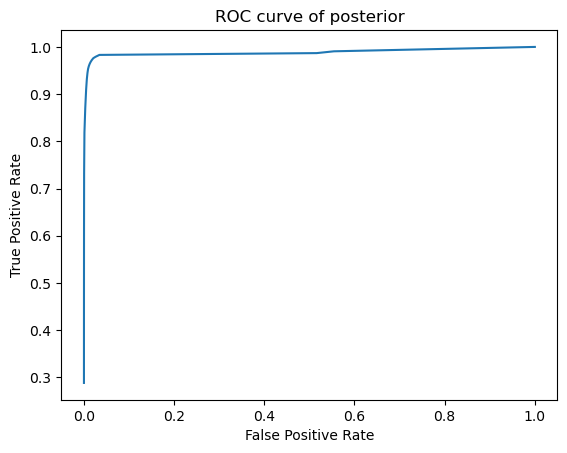

In [80]:
#Plot results and posterior image vs ground truth mask
plt.plot(false_positive_rate, true_positive_rate)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve of posterior")
plt.show

Text(0.5, 1.0, 'Posterior Image')

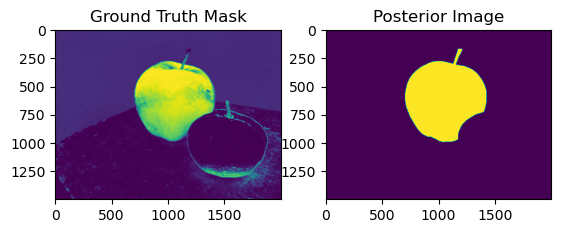

In [81]:
fig,(ax1,ax2) = plt.subplots(1,2)
ax1.imshow(posterior_list[2])
ax2.imshow(test_mask_image[0])
ax1.set_title("Ground Truth Mask")
ax2.set_title("Posterior Image")

In subsection D, we have attempted to quantify the correctness of our prediction posterior for the provided test data via an ROC curve.
\
\
How to read an ROC curve? From what I understood from the provided resources, we want to maximise true positive rate while minimising false positive rate.
\
\
We can see from the ROC curve above, our model has done a really good job at predicting/recognising the apple in the image, as we acquire a very high true positive rate (more than 0.95) for a very low false positive rate (0 to 0.05).
\
\
However, ROC curves for the rest of the testing images should also be drawn, as we have chosen the image that our model performs the best with, leading us to bias assumptions of the model.

## Subsection E

Although I add more than two pictures just for me to draw better conclusions from the model, I only draw ROC curves for three of them.

In [82]:
#Load in the images I selected
images = glob.glob("my_apples/*.jpg")
validation_images_list = []
for image in images:
    im = plt.imread(image)
    validation_images_list.append(im/255)

In [83]:
#Create their posteriors
posterior_myapples_list = posterior(validation_images_list, apple_prior, apple_not_prior, mix_gauss_dict_apple, mix_gauss_dict_apple_not)

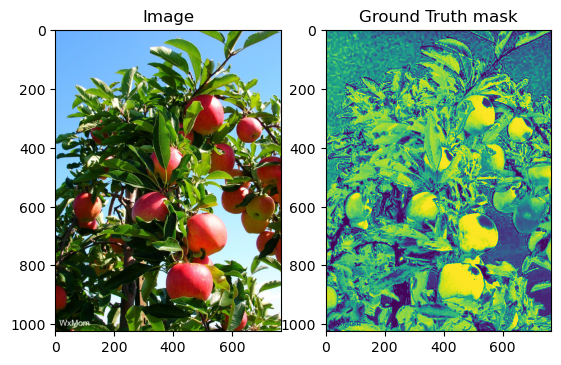

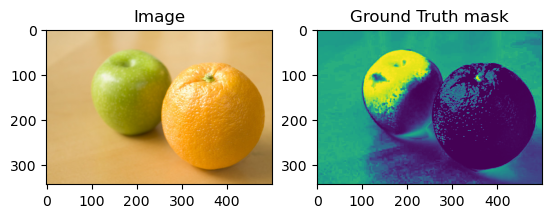

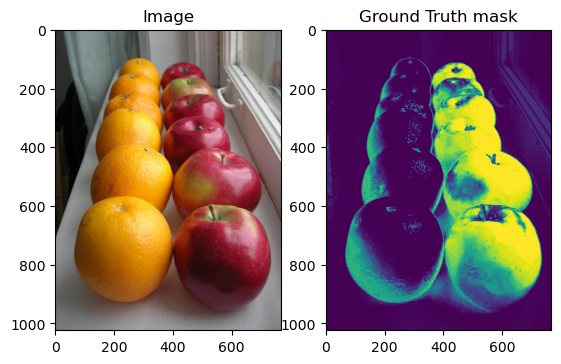

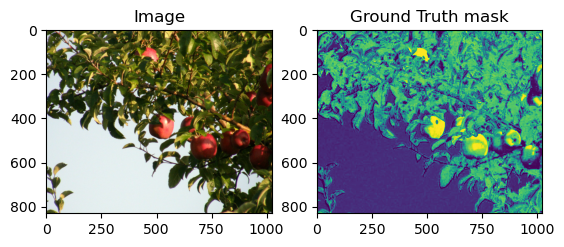

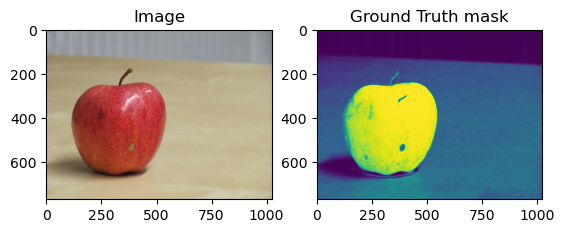

In [84]:
#Plot posteriors
for n in range(len(validation_images_list)):
    fig,(ax1,ax2) = plt.subplots(1,2)
    ax1.imshow(validation_images_list[n])
    ax1.set_title('Image')
    ax2.imshow(posterior_myapples_list[n])
    ax2.set_title('Ground Truth mask')

Let's draw ROC curves for the second, third and the fourth picture.

Text(0.5, 1.0, 'Ground Truth mask')

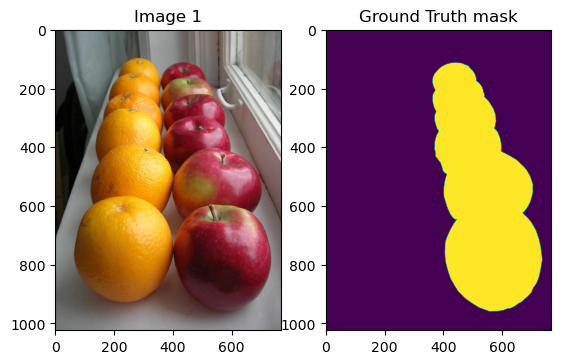

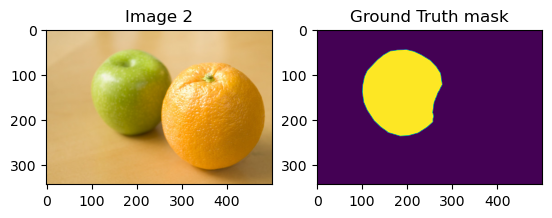

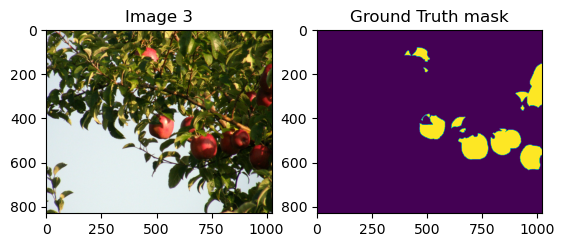

In [85]:
#Load in ground truth masks
images = glob.glob("my_apples/*.png")
ground_truth_mask_images_list = []
for image in images:
    im = plt.imread(image)
    ground_truth_mask_images_list.append(im[:,:,1])

#Plot to know positions of mask images in list

fig,(ax1,ax2) = plt.subplots(1,2)
ax1.imshow(validation_images_list[2])
ax1.set_title('Image 1')
ax2.imshow(ground_truth_mask_images_list[0])
ax2.set_title('Ground Truth mask')

fig,(ax1,ax2) = plt.subplots(1,2)
ax1.imshow(validation_images_list[1])
ax1.set_title('Image 2')
ax2.imshow(ground_truth_mask_images_list[1])
ax2.set_title('Ground Truth mask')

fig,(ax1,ax2) = plt.subplots(1,2)
ax1.imshow(validation_images_list[3])
ax1.set_title('Image 3')
ax2.imshow(ground_truth_mask_images_list[2])
ax2.set_title('Ground Truth mask')

In [86]:
threshold_epsilon = 0.05
true_positive_rate_myapple_1, false_positive_rate_myapple_1 = ROC(threshold_epsilon, posterior_myapples_list[2], ground_truth_mask_images_list[0])
true_positive_rate_myapple_2, false_positive_rate_myapple_2 = ROC(threshold_epsilon, posterior_myapples_list[1], ground_truth_mask_images_list[1])
true_positive_rate_myapple_3, false_positive_rate_myapple_3 = ROC(threshold_epsilon, posterior_myapples_list[3], ground_truth_mask_images_list[2])

<function matplotlib.pyplot.show(close=None, block=None)>

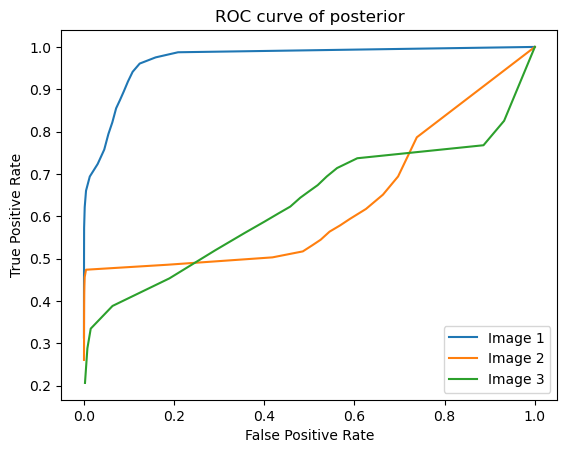

In [87]:
#Plot both ROC curves
""" fig,(ax1,ax2) = plt.subplots(1,2)
ax1.plot(false_positive_rate_myapple_1, true_positive_rate_myapple_1)
ax1.set_title('Image 1')
ax2.plot(false_positive_rate_myapple_2, true_positive_rate_myapple_2)
ax2.set_title('Image 2') """
plt.plot(false_positive_rate_myapple_1, true_positive_rate_myapple_1, label = "Image 1")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve of posterior")

plt.plot(false_positive_rate_myapple_2, true_positive_rate_myapple_2, label = "Image 2")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve of posterior")

plt.plot(false_positive_rate_myapple_3, true_positive_rate_myapple_3, label = "Image 3")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve of posterior")

plt.legend()
plt.show


In subsection E, we have attempted to further test our model by quantifying the "correctness" of the predicted posteriors via their ROC curves, as shown above.
\
\
As one can tell from the posterior images and the ROC curves, our model performs the best with optimal light coniditions (no shadows nor too much brightness reflected off apples) and with lack of green non-apples objects. Image 2  and 3 are a great example of this. In image 2 our model does a good job at recognising the apple up to its shaded area. In image 3 our model struggles to recognise green non apple objects as such.
\
\
However, when conditions are optimal, our model does a good/okay (false positive rate is considerable at around 0.2) job at recognising apples as shown in image 1. This can be further quantified by its ROC curve displayed above.

## Subsection F

Validation set can be used as the final test data to determine wether we have overfit our model or not.
\
\
Validation set should not be used at all throughout the training or the testing of the model. Only when one is satisfied with the acquired model should he/she validate it through the validation set.
\
\
Without a validation set, one can overfit the model to the testing data (testing set) by tweaking the model to reduce testing accuracy only. Thus, resulting in a model that does a good job at predicting the testing data but a poor job everywhere else.
\
\
How can one ensure he has not produced a model that overfitted to testing data? One can also study training accuracy, as it would be low if the model overfitted to testing data.
\
\
By balancing these parameters and tuning our model's parameters through, for example, k-fold validation, one can use the validation set as re-assurance of the validity of the model.
\
\
Furthermore, the validation set can be used to compare models.

Taking our exercise as an example, we trained the model in subsection B, acquired prediction of testing data in subsection C, quantified the prediction's accuracy in subsection D and, after seeing good testing accuracy via our ROC curve, attempted to validate the model in subsection E. However, we have not used any method to tune the number of multivariate gaussians we wanted to fit our data with (parameter k). Such parameter choice was agreed upon via our personal bias (one could also considerate a prior), as explained above.